In [101]:
pip install getout_of_text_3


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Demonstration notebook for functionalities to include on GOT3 tool

- working through some steps with `pandas` and`nltk`, to later roll into the toolset `getout_of_text_3` to streamline COCA Corpora searching

In [12]:
import getout_of_text_3 as got3
got3.__version__

'0.1.3'

In [13]:
import pandas as pd
# Import necessary libraries for search functionality
import nltk
import re
from collections import defaultdict, Counter

In [18]:
# Download NLTK data
try:
    nltk.download('punkt_tab', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("✅ NLTK libraries ready!")
except:
    print("⚠️ NLTK download may have failed, but will continue")

# Test tokenization
try:
    test_words = nltk.word_tokenize("This is a test.")
    print(f"✅ Tokenization working: {test_words}")
except Exception as e:
    print(f"⚠️ Tokenization issue: {e}")
    print("Will use simple split() method as fallback")

✅ NLTK libraries ready!
✅ Tokenization working: ['This', 'is', 'a', 'test', '.']


## reading coca db and txt
- dictionaries with genre as the key and dfs as the value

In [14]:
genre_dict = ['acad', 'blog', 'fic', 
              'mag', 'news', 'spok',
              'tvm', 'web']
db_df = {}
db_text = {}

In [31]:
for genre in genre_dict:
    print(f"📂 Processing {genre}...")
    
    # Load db file
    try:
        db_df[genre] = pd.read_csv("../coca-samples-db/db_{}.txt".format(genre), 
                                   sep="\t", 
                                   header=None, 
                                   names=["text"],
                                   on_bad_lines='skip',
                                   quoting=3)
        print(f"  ✅ db_{genre}.txt: {db_df[genre].shape}")
    except Exception as e:
        print(f"  ❌ Error reading db_{genre}: {e}")
    
    # Load text file
    try:
        db_text[genre] = pd.read_csv("../coca-samples-text/text_{}.txt".format(genre), 
                                     sep="\t", 
                                     header=None, 
                                     names=["text"],
                                     on_bad_lines='skip',
                                     quoting=3)
        print(f"  ✅ text_{genre}.txt: {db_text[genre].shape}")
    except Exception as e:
        print(f"  ❌ Error reading text_{genre}: {e}")

print(f"\n🎯 SUMMARY:")
print(f"   - db_df: {len(db_df)} genres loaded") 
print(f"   - db_text: {len(db_text)} genres loaded")
print(f"   - Processed each genre exactly once ✅")

Reading files for... acad
  db_acad.txt: (1419500, 1)
  text_acad.txt: (265, 1)
Reading files for... blog
  db_acad.txt: (1419500, 1)
  text_acad.txt: (265, 1)
Reading files for... blog
  db_blog.txt: (1586094, 1)
  text_blog.txt: (991, 1)
Reading files for... fic
  db_blog.txt: (1586094, 1)
  text_blog.txt: (991, 1)
Reading files for... fic
  db_fic.txt: (1405902, 1)
  text_fic.txt: (273, 1)
Reading files for... mag
  db_fic.txt: (1405902, 1)
  text_fic.txt: (273, 1)
Reading files for... mag
  db_mag.txt: (1567102, 1)
  text_mag.txt: (948, 1)
Reading files for... news
  db_mag.txt: (1567102, 1)
  text_mag.txt: (948, 1)
Reading files for... news
  db_news.txt: (1389753, 1)
  text_news.txt: (871, 1)
Reading files for... spok
  db_news.txt: (1389753, 1)
  text_news.txt: (871, 1)
Reading files for... spok
  db_spok.txt: (1160506, 1)
  text_spok.txt: (263, 1)
Reading files for... tvm
  db_spok.txt: (1160506, 1)
  text_spok.txt: (263, 1)
Reading files for... tvm
  db_tvm.txt: (1567561, 1)
 

## For collocate or keyword searches, we can use the following approach:
1. loop through each genre
2. do string filter hits for each instance of a string match in the dictionary key dataframe text column
3. print out in an elegant manner

use NLTK for this if that makes things easier!

In [97]:
def search_keyword_corpus(keyword, db_dict, case_sensitive=False, show_context=True, context_words=5):
    """
    Search for a keyword across all COCA genres and display results elegantly.
    
    Parameters:
    - keyword: The word/phrase to search for
    - db_dict: Dictionary of DataFrames (either db_df or db_text)
    - case_sensitive: Whether to perform case-sensitive search
    - show_context: Whether to show surrounding context
    - context_words: Number of words to show on each side for context
    
    Returns:
    - Dictionary with search results by genre
    """
    
    print(f"🔍 COCA Corpus Search: '{keyword}'")
    print("=" * 60)
    
    results = defaultdict(list)
    total_hits = 0
    
    # Prepare search pattern
    if case_sensitive:
        pattern = re.compile(r'\b' + re.escape(keyword) + r'\b')
    else:
        pattern = re.compile(r'\b' + re.escape(keyword) + r'\b', re.IGNORECASE)
    
    # Search through each genre
    for genre, df in db_dict.items():
        genre_hits = 0
        print(f"\n📚 {genre.upper()} Genre:")
        print("-" * 30)
        
        for idx, text in df['text'].items():
            text_str = str(text)
            matches = pattern.findall(text_str)
            
            if matches:
                genre_hits += len(matches)
                
                if show_context:
                    # Find all match positions and show context
                    for match in pattern.finditer(text_str):
                        start, end = match.span()
                        
                        # Get context words
                        words = text_str.split()
                        text_words = ' '.join(words)
                        
                        # Find word boundaries for context
                        words_before_match = text_str[:start].split()
                        words_after_match = text_str[end:].split()
                        
                        # Build context
                        context_before = ' '.join(words_before_match[-context_words:]) if words_before_match else ""
                        matched_word = text_str[start:end]
                        context_after = ' '.join(words_after_match[:context_words]) if words_after_match else ""
                        
                        # Format the context nicely
                        context_display = f"...{context_before} **{matched_word}** {context_after}..."
                        context_display = context_display.replace("...", "").strip()
                        
                        results[genre].append({
                            'text_id': idx,
                            'match': matched_word,
                            'context': context_display,
                            'full_text': text_str[:100] + "..." if len(text_str) > 100 else text_str
                        })
                        
                        print(f"  📝 Text {idx}: {context_display}")
                else:
                    results[genre].append({
                        'text_id': idx,
                        'matches': len(matches),
                        'full_text': text_str[:100] + "..." if len(text_str) > 100 else text_str
                    })
        
        if genre_hits > 0:
            print(f"  ✅ Found {genre_hits} occurrence(s) in {genre}")
        else:
            print(f"  ❌ No matches found in {genre}")
            
        total_hits += genre_hits
    
    print(f"\n🎯 SUMMARY:")
    print(f"Total hits across all genres: {total_hits}")
    print(f"Genres with matches: {len([g for g in results if results[g]])}")
    
    return dict(results)

# Helper function for frequency analysis
def keyword_frequency_analysis(keyword, db_dict, case_sensitive=False):
    """
    Analyze frequency of keyword across genres
    """
    print(f"📊 Frequency Analysis for '{keyword}'")
    print("=" * 50)
    
    freq_data = {}
    
    if case_sensitive:
        pattern = re.compile(r'\b' + re.escape(keyword) + r'\b')
    else:
        pattern = re.compile(r'\b' + re.escape(keyword) + r'\b', re.IGNORECASE)
    
    for genre, df in db_dict.items():
        total_words = 0
        keyword_count = 0
        
        for text in df['text']:
            text_str = str(text)
            words = text_str.split()
            total_words += len(words)
            keyword_count += len(pattern.findall(text_str))
        
        # Calculate frequency per 1000 words
        freq_per_1000 = (keyword_count / total_words * 1000) if total_words > 0 else 0
        
        freq_data[genre] = {
            'count': keyword_count,
            'total_words': total_words,
            'freq_per_1000': round(freq_per_1000, 3)
        }
        
        print(f"{genre:8s}: {keyword_count:4d} occurrences | {freq_per_1000:6.3f} per 1000 words")
    
    return freq_data

print("✅ Search functions created successfully!")

✅ Search functions created successfully!


In [98]:
# Example 1: Search for a legal term across all genres
keyword = "textual"
search_results = search_keyword_corpus(keyword, db_text, case_sensitive=False, show_context=True, context_words=5)

🔍 COCA Corpus Search: 'textual'

📚 ACAD Genre:
------------------------------
  📝 Text 4: New Testaments , of multiple **textual** layers . In fact ,
  📝 Text 4: little evolving world of complex **textual** strata . As in The
  📝 Text 4: its own complicated pastiche of **textual** fragments recounted by at least
  📝 Text 31: basis for multiple languages -- **textual** , graphic , photographic ,
  📝 Text 73: describes television as " the **textual** technology of information theory ,
  📝 Text 78: a chorus-commentary underline the irritating **textual** bombardment , while a stereophonic
  📝 Text 87: distinction between an intrinsic , **textual** " you " -- a
  📝 Text 87: this page " is both **textual** and extratextual : it refers
  📝 Text 87: play with the location ( **textual** and/or extratextual ) of the
  📝 Text 87: there is some evidence ( **textual** or historical ) to the
  📝 Text 87: there is some evidence ( **textual** or historical ) to the
  📝 Text 87: that involves discussi

In [99]:
# Example 2: Frequency analysis across genres
print("\n" + "="*60)
freq_results = keyword_frequency_analysis(keyword, db_text, case_sensitive=False)


📊 Frequency Analysis for 'textual'
acad    :   21 occurrences |  0.015 per 1000 words
blog    :    2 occurrences |  0.001 per 1000 words
blog    :    2 occurrences |  0.001 per 1000 words
fic     :    1 occurrences |  0.001 per 1000 words
fic     :    1 occurrences |  0.001 per 1000 words
mag     :    0 occurrences |  0.000 per 1000 words
mag     :    0 occurrences |  0.000 per 1000 words
news    :    0 occurrences |  0.000 per 1000 words
spok    :    0 occurrences |  0.000 per 1000 words
news    :    0 occurrences |  0.000 per 1000 words
spok    :    0 occurrences |  0.000 per 1000 words
tvm     :    0 occurrences |  0.000 per 1000 words
tvm     :    0 occurrences |  0.000 per 1000 words
web     :    2 occurrences |  0.001 per 1000 words
web     :    2 occurrences |  0.001 per 1000 words


In [100]:
def find_collocates(keyword, db_dict, window_size=5, min_freq=2, case_sensitive=False):
    """
    Find words that frequently appear near the keyword (collocates)
    
    Parameters:
    - keyword: Target word to find collocates for
    - db_dict: Dictionary of DataFrames
    - window_size: Number of words to look at on each side
    - min_freq: Minimum frequency for a word to be considered a collocate
    - case_sensitive: Whether to perform case-sensitive search
    """
    print(f"🔗 Collocate Analysis for '{keyword}' (window: ±{window_size} words)")
    print("=" * 60)
    
    if case_sensitive:
        pattern = re.compile(r'\b' + re.escape(keyword) + r'\b')
    else:
        pattern = re.compile(r'\b' + re.escape(keyword) + r'\b', re.IGNORECASE)
    
    all_collocates = Counter()
    genre_collocates = {}

    for genre, df in db_dict.items():
        print(f"\n📚 {genre.upper()} Genre Collocates:")
        
        # Create a fresh counter for each genre
        genre_counter = Counter()
        keyword_instances = 0
        
        for text in df['text']:
            text_str = str(text).lower() if not case_sensitive else str(text)
            words = nltk.word_tokenize(text_str)
            
            # Find all positions of the keyword
            keyword_positions = []
            for i, word in enumerate(words):
                if (not case_sensitive and word.lower() == keyword.lower()) or (case_sensitive and word == keyword):
                    keyword_positions.append(i)
            
            keyword_instances += len(keyword_positions)
            
            # Extract collocates around each keyword occurrence
            for pos in keyword_positions:
                start = max(0, pos - window_size)
                end = min(len(words), pos + window_size + 1)
                
                # Get surrounding words (excluding the keyword itself)
                context_words = words[start:pos] + words[pos+1:end]
                
                # Filter out punctuation and very short words
                context_words = [w for w in context_words if w.isalpha() and len(w) > 2]
                
                genre_counter.update(context_words)
                all_collocates.update(context_words)
        
        # Store the results for this genre
        genre_collocates[genre] = genre_counter
        
        # Display top collocates for this genre
        top_collocates = genre_counter.most_common(10)
        if top_collocates:
            print(f"  Found {keyword_instances} instances of '{keyword}' in {genre}")
            # Show all results, but mark those below min_freq
            for word, freq in top_collocates:
                marker = "  " if freq >= min_freq else "* "
                print(f"{marker}{word:15s}: {freq:3d} times")
        else:
            print(f"  Found {keyword_instances} instances, but no significant collocates")
    
    print(f"\n🎯 TOP OVERALL COLLOCATES (min frequency: {min_freq}):")
    print("-" * 40)
    top_overall = all_collocates.most_common(20)
    for word, freq in top_overall:
        if freq >= min_freq:
            print(f"{word:15s}: {freq:3d} occurrences")
        
    return {
        'all_collocates': dict(all_collocates),
        'by_genre': dict(genre_collocates),
        #'top_overall': top_overall
    }

# Example 3: Find collocates for the keyword (CLEANED VERSION)
print("\n" + "="*60)
print("🔧 CLEANED COLLOCATE ANALYSIS:")
collocate_results = find_collocates('help', db_text, window_size=3, min_freq=1)


🔧 CLEANED COLLOCATE ANALYSIS:
🔗 Collocate Analysis for 'help' (window: ±3 words)

📚 ACAD Genre Collocates:
  Found 434 instances of 'help' in acad
  the            : 126 times
  and            :  67 times
  can            :  56 times
  that           :  42 times
  with           :  36 times
  students       :  36 times
  will           :  28 times
  may            :  27 times
  for            :  27 times
  them           :  20 times

📚 BLOG Genre Collocates:
  Found 434 instances of 'help' in acad
  the            : 126 times
  and            :  67 times
  can            :  56 times
  that           :  42 times
  with           :  36 times
  students       :  36 times
  will           :  28 times
  may            :  27 times
  for            :  27 times
  them           :  20 times

📚 BLOG Genre Collocates:
  Found 701 instances of 'help' in blog
  the            : 189 times
  you            :  98 times
  and            :  97 times
  that           :  69 times
  can            :  55 t

KeyboardInterrupt: 

### think about how it's helpful to have these various results displayed / consumed by the user

The `got3` tool should have the following included steps for ease of access with working with COCA from BYU

1. read the database files `got3.read_corpora(dir_of_text_files,corpora_name)`
2. perform collocate analysis using `got3.find_collocates(keyword, db_dict, window_size, min_freq, case_sensitive)`
3. perform keyword search using `got3.search_keyword_corpus(keyword, db_dict, case_sensitive, show_context, context_words)`
4. perform keyword frequency analysis using `got3.keyword_frequency_analysis(keyword, db_dict, case_sensitive)`

### Including BERT for Embedding Models

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [84]:
# Load BERT model for embeddings
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set to evaluation mode

def bert_tokenize_corpus(corpus_data, max_length=512):
    """
    Tokenize corpus texts using BERT tokenizer
    
    Parameters:
    - corpus_data: pandas Series or dict containing text data
    - max_length: maximum sequence length for BERT
    
    Returns:
    - Dictionary with tokenized inputs
    """
    tokenized_corpus = {}
    
    # Handle pandas Series
    if hasattr(corpus_data, 'items'):
        items = corpus_data.items()
    else:
        items = enumerate(corpus_data)
    
    print(f"🤗 Tokenizing corpus with BERT (max_length={max_length})...")
    
    for doc_id, text in items:
        if pd.isna(text) or str(text).strip() == '':
            continue
            
        text_str = str(text)
        
        # Tokenize with BERT
        inputs = tokenizer(
            text_str, 
            return_tensors="pt", 
            max_length=max_length, 
            truncation=True,
            padding='max_length',
            return_attention_mask=True
        )
        
        tokenized_corpus[doc_id] = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'original_text': text_str[:200] + "..." if len(text_str) > 200 else text_str
        }
    
    print(f"✅ Tokenized {len(tokenized_corpus)} documents")
    return tokenized_corpus

# Tokenize the academic corpus
print("🎯 Tokenizing Academic Corpus...")
bert_corpus = bert_tokenize_corpus(db_text['acad']['text'])

🎯 Tokenizing Academic Corpus...
🤗 Tokenizing corpus with BERT (max_length=512)...
✅ Tokenized 265 documents
✅ Tokenized 265 documents


In [85]:
def generate_bert_embeddings(tokenized_corpus, batch_size=8):
    """
    Generate BERT embeddings for tokenized corpus
    
    Parameters:
    - tokenized_corpus: Output from bert_tokenize_corpus
    - batch_size: Number of documents to process at once
    
    Returns:
    - Dictionary with document embeddings
    """
    embeddings = {}
    doc_ids = list(tokenized_corpus.keys())
    
    print(f"🧠 Generating BERT embeddings for {len(doc_ids)} documents...")
    
    with torch.no_grad():
        for i in range(0, len(doc_ids), batch_size):
            batch_ids = doc_ids[i:i+batch_size]
            
            # Prepare batch
            input_ids_batch = torch.cat([tokenized_corpus[doc_id]['input_ids'] 
                                       for doc_id in batch_ids], dim=0)
            attention_masks_batch = torch.cat([tokenized_corpus[doc_id]['attention_mask'] 
                                             for doc_id in batch_ids], dim=0)
            
            # Get BERT outputs
            outputs = model(input_ids=input_ids_batch, attention_mask=attention_masks_batch)
            
            # Use [CLS] token embedding as document representation
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: [batch_size, 768]
            
            # Store embeddings
            for j, doc_id in enumerate(batch_ids):
                embeddings[doc_id] = {
                    'embedding': cls_embeddings[j].numpy(),
                    'original_text': tokenized_corpus[doc_id]['original_text']
                }
            
            print(f"  ✅ Processed batch {i//batch_size + 1}/{(len(doc_ids)-1)//batch_size + 1}")
    
    print(f"🎯 Generated embeddings for {len(embeddings)} documents")
    return embeddings

# Generate embeddings for a sample of the corpus (first 10 documents for demo)
sample_corpus = {k: v for k, v in list(bert_corpus.items())[:10]}
bert_embeddings = generate_bert_embeddings(sample_corpus, batch_size=4)

🧠 Generating BERT embeddings for 10 documents...
  ✅ Processed batch 1/3
  ✅ Processed batch 1/3
  ✅ Processed batch 2/3
  ✅ Processed batch 3/3
🎯 Generated embeddings for 10 documents
  ✅ Processed batch 2/3
  ✅ Processed batch 3/3
🎯 Generated embeddings for 10 documents


In [92]:
def find_similar_documents(query_text, bert_embeddings, tokenizer, model, top_k=5):
    """
    Find documents most similar to a query text using BERT embeddings
    
    Parameters:
    - query_text: Text to find similar documents for
    - bert_embeddings: Dictionary of document embeddings
    - tokenizer: BERT tokenizer
    - model: BERT model
    - top_k: Number of most similar documents to return
    
    Returns:
    - List of tuples (doc_id, similarity_score, text_preview)
    """
    print(f"🔍 Finding documents similar to: '{query_text[:100]}...'")
    
    # Generate embedding for query text
    with torch.no_grad():
        query_inputs = tokenizer(
            query_text, 
            return_tensors="pt", 
            max_length=512, 
            truncation=True,
            padding='max_length'
        )
        query_outputs = model(input_ids=query_inputs['input_ids'], 
                            attention_mask=query_inputs['attention_mask'])
        query_embedding = query_outputs.last_hidden_state[:, 0, :].numpy()[0]
    
    # Calculate similarities
    similarities = []
    for doc_id, doc_data in bert_embeddings.items():
        doc_embedding = doc_data['embedding']
        
        # Calculate cosine similarity
        similarity = 1 - cosine(query_embedding, doc_embedding)
        similarities.append((doc_id, similarity, doc_data['original_text']))
    
    # Sort by similarity and return top k
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    print(f"📊 Top {top_k} most similar documents:")
    for i, (doc_id, sim_score, text_preview) in enumerate(similarities[:top_k]):
        print(f"  {i+1}. Doc {doc_id} (similarity: {sim_score:.4f})")
        print(f"     Preview: {text_preview[:150]}...")
        print()
    
    return similarities[:top_k]

def bert_based_keyword_context(keyword, bert_embeddings, tokenizer, model, context_window=50):
    """
    Find documents containing a keyword and analyze their BERT-based semantic context
    
    Parameters:
    - keyword: Keyword to search for
    - bert_embeddings: Dictionary of document embeddings  
    - tokenizer: BERT tokenizer
    - model: BERT model
    - context_window: Characters around keyword to show
    
    Returns:
    - Dictionary with keyword contexts and their embeddings
    """
    print(f"🔎 BERT-based keyword analysis for: '{keyword}'")
    
    keyword_contexts = {}
    
    for doc_id, doc_data in bert_embeddings.items():
        text = doc_data['original_text']
        
        # Find keyword occurrences
        text_lower = text.lower()
        keyword_lower = keyword.lower()
        
        if keyword_lower in text_lower:
            # Find all occurrences
            start = 0
            occurrences = []
            
            while True:
                pos = text_lower.find(keyword_lower, start)
                if pos == -1:
                    break
                
                # Extract context
                context_start = max(0, pos - context_window)
                context_end = min(len(text), pos + len(keyword) + context_window)
                context = text[context_start:context_end]
                
                occurrences.append({
                    'position': pos,
                    'context': context,
                    'keyword_start': pos - context_start,
                    'keyword_end': pos - context_start + len(keyword)
                })
                
                start = pos + 1
            
            if occurrences:
                keyword_contexts[doc_id] = {
                    'embedding': doc_data['embedding'],
                    'occurrences': occurrences,
                    'full_text': text
                }
    
    print(f"📈 Found '{keyword}' in {len(keyword_contexts)} documents")
    
    # Show context examples
    for doc_id, data in list(keyword_contexts.items())[:3]:  # Show first 3 examples
        print(f"\n📝 Document {doc_id}:")
        for i, occ in enumerate(data['occurrences'][:2]):  # Show first 2 occurrences per doc
            context = occ['context']
            start, end = occ['keyword_start'], occ['keyword_end']
            highlighted = context[:start] + f"**{context[start:end]}**" + context[end:]
            print(f"   Context {i+1}: ...{highlighted}...")
    
    return keyword_contexts

# Example usage: Find documents similar to a legal query
query = "get out of text free card"
similar_docs = find_similar_documents(query, bert_embeddings, tokenizer, model, top_k=3)

print("\n" + "="*60)

# Example usage: BERT-based keyword analysis
keyword_analysis = bert_based_keyword_context("help", bert_embeddings, tokenizer, model)

🔍 Finding documents similar to: 'get out of text free card...'
📊 Top 3 most similar documents:
  1. Doc 0 (similarity: 0.6984)
     Preview: @@4000241 I think it is safe to say that ours is the only dining room in West Los Angeles on whose table -- an eight-foot-long , two-hundred-pound beh...

  2. Doc 5 (similarity: 0.6897)
     Preview: @@4000941 The expression " sent up the river " finds its roots in New York penal history . From the early 1800s on , convicted felons from New York Ci...

  3. Doc 1 (similarity: 0.6870)
     Preview: @@4000341 The high point of my freshman-year English literature survey course , taught by that sweet man and Emily Dickinson biographer Richard Sewall...


🔎 BERT-based keyword analysis for: 'help'
📈 Found 'help' in 0 documents


🎯 Clustering 10 documents into 3 clusters using BERT embeddings...

📊 CLUSTER ANALYSIS RESULTS:

🗂️  Cluster_0 (5 documents):
   • Doc 1: @@4000341 The high point of my freshman-year English literature survey course , taught by that sweet...
   • Doc 2: @@4000441 There seems only one cause behind all forms of social misery : bigness . It appears to be ...
   • Doc 3: @@4000541 The papers that comprise this symposium are adapted from remarks delivered on 31 May 2002 ...
   ... and 2 more documents

🗂️  Cluster_1 (2 documents):
   • Doc 7: @@4001341 A computerized block design task was developed which records temporal and nontemporal meas...
   • Doc 8: @@4001441 Our purpose in this study is to view theories of psychotherapy from a general social-polit...

🗂️  Cluster_2 (3 documents):
   • Doc 0: @@4000241 I think it is safe to say that ours is the only dining room in West Los Angeles on whose t...
   • Doc 5: @@4000941 The expression " sent up the river " finds its roots in New York pen

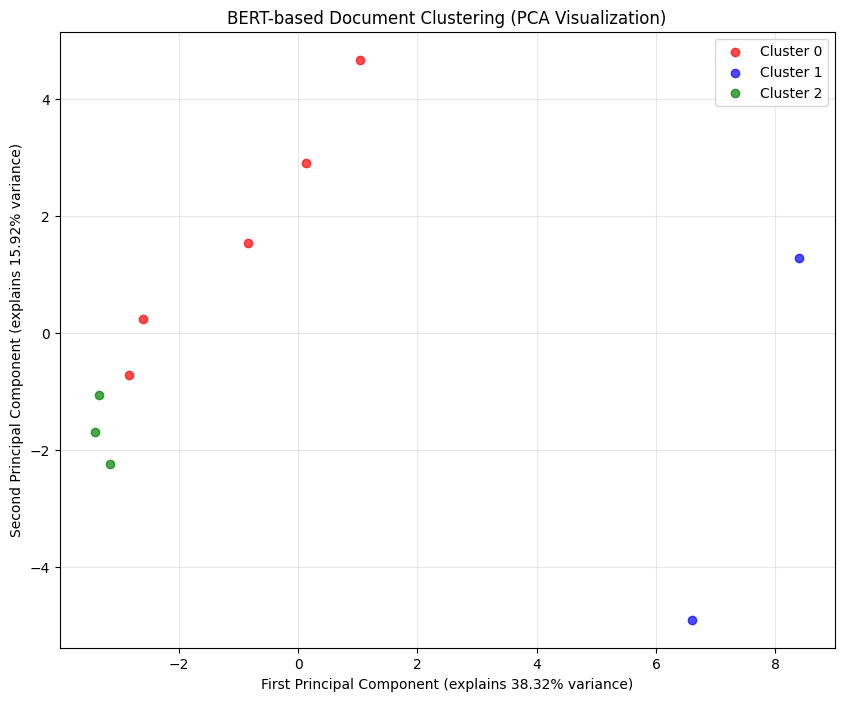


⚖️  LEGAL CONCEPT SEMANTIC SEARCH

🔍 Searching for: 'constitutional rights and amendments'
🔍 Finding documents similar to: 'constitutional rights and amendments...'
📊 Top 3 most similar documents:
  1. Doc 0 (similarity: 0.6513)
     Preview: @@4000241 I think it is safe to say that ours is the only dining room in West Los Angeles on whose table -- an eight-foot-long , two-hundred-pound beh...

  2. Doc 5 (similarity: 0.6355)
     Preview: @@4000941 The expression " sent up the river " finds its roots in New York penal history . From the early 1800s on , convicted felons from New York Ci...

  3. Doc 6 (similarity: 0.6260)
     Preview: @@4001041 ONE OF THE MOST PROMINENT causal factors of the seemingly rebounding addiction to supernaturalism as an explanation of the world and justifi...


🔍 Searching for: 'judicial interpretation and precedent'
🔍 Finding documents similar to: 'judicial interpretation and precedent...'
📊 Top 3 most similar documents:
  1. Doc 6 (similarity: 0.6215)
  

In [95]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def bert_document_clustering(bert_embeddings, n_clusters=3, visualize=True):
    """
    Cluster documents based on BERT embeddings
    
    Parameters:
    - bert_embeddings: Dictionary of document embeddings
    - n_clusters: Number of clusters to create
    - visualize: Whether to create a visualization
    
    Returns:
    - Dictionary with cluster assignments and analysis
    """
    print(f"🎯 Clustering {len(bert_embeddings)} documents into {n_clusters} clusters using BERT embeddings...")
    
    # Prepare embeddings matrix
    doc_ids = list(bert_embeddings.keys())
    embeddings_matrix = np.array([bert_embeddings[doc_id]['embedding'] for doc_id in doc_ids])
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_matrix)
    
    # Organize results by cluster
    clusters = {}
    for i in range(n_clusters):
        clusters[f'Cluster_{i}'] = []
    
    for doc_id, cluster_label in zip(doc_ids, cluster_labels):
        cluster_name = f'Cluster_{cluster_label}'
        clusters[cluster_name].append({
            'doc_id': doc_id,
            'text_preview': bert_embeddings[doc_id]['original_text'][:100] + "..."
        })
    
    # Display cluster information
    print("\n📊 CLUSTER ANALYSIS RESULTS:")
    print("=" * 50)
    
    for cluster_name, docs in clusters.items():
        print(f"\n🗂️  {cluster_name} ({len(docs)} documents):")
        for doc in docs[:3]:  # Show first 3 documents per cluster
            print(f"   • Doc {doc['doc_id']}: {doc['text_preview']}")
        if len(docs) > 3:
            print(f"   ... and {len(docs) - 3} more documents")
    
    # Visualization
    if visualize and len(bert_embeddings) > 2:
        print("\n📈 Creating visualization...")
        
        # Reduce dimensionality for visualization
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings_matrix)
        
        plt.figure(figsize=(10, 8))
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        
        for i in range(n_clusters):
            cluster_mask = cluster_labels == i
            plt.scatter(embeddings_2d[cluster_mask, 0], 
                       embeddings_2d[cluster_mask, 1], 
                       c=colors[i % len(colors)], 
                       label=f'Cluster {i}',
                       alpha=0.7)
        
        plt.title('BERT-based Document Clustering (PCA Visualization)')
        plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'clusters': clusters,
        'cluster_labels': cluster_labels,
        'doc_ids': doc_ids,
        'embeddings_matrix': embeddings_matrix,
        'kmeans_model': kmeans
    }

def bert_semantic_search_legal_concepts(bert_embeddings, legal_concepts, tokenizer, model):
    """
    Search for documents related to specific legal concepts using BERT semantic similarity
    
    Parameters:
    - bert_embeddings: Dictionary of document embeddings
    - legal_concepts: List of legal concept queries
    - tokenizer: BERT tokenizer
    - model: BERT model
    
    Returns:
    - Dictionary mapping concepts to most relevant documents
    """
    concept_matches = {}
    
    print("⚖️  LEGAL CONCEPT SEMANTIC SEARCH")
    print("=" * 50)
    
    for concept in legal_concepts:
        print(f"\n🔍 Searching for: '{concept}'")
        
        # Find similar documents for this concept
        similar_docs = find_similar_documents(
            concept, bert_embeddings, tokenizer, model, top_k=3
        )
        
        concept_matches[concept] = similar_docs
    
    return concept_matches

# Example usage: Cluster the documents
clustering_results = bert_document_clustering(bert_embeddings, n_clusters=3, visualize=True)

print("\n" + "="*60)

# Example usage: Semantic search for legal concepts
legal_concepts = [
    "constitutional rights and amendments",
    "judicial interpretation and precedent", 
    "legal procedure and court process"
]

concept_search_results = bert_semantic_search_legal_concepts(
    bert_embeddings, legal_concepts, tokenizer, model
)

In [103]:
## Integration with got3 toolkit for enhanced legal corpus analysis

def create_bert_enhanced_corpus_analysis(corpus_data, keywords, legal_concepts):
    """
    Combine traditional got3 analysis with BERT-based semantic analysis
    
    Parameters:
    - corpus_data: COCA corpus data from got3.read_corpora()
    - keywords: List of keywords for traditional analysis
    - legal_concepts: List of legal concepts for BERT semantic analysis
    
    Returns:
    - Comprehensive analysis results combining both approaches
    """
    results = {
        'traditional_analysis': {},
        'bert_analysis': {},
        'combined_insights': {}
    }
    
    print("🎯 COMPREHENSIVE LEGAL CORPUS ANALYSIS")
    print("=" * 60)
    print("Combining traditional got3 methods with BERT semantic analysis...")
    
    # Traditional got3 analysis
    print("\n📚 TRADITIONAL ANALYSIS (got3 methods):")
    print("-" * 40)
    
    for keyword in keywords:
        print(f"\n🔍 Analyzing keyword: '{keyword}'")
        
        # Traditional keyword search
        search_results = search_keyword_corpus(keyword, corpus_data, show_context=False)
        
        # Frequency analysis  
        freq_results = keyword_frequency_analysis(keyword, corpus_data)
        
        # Collocate analysis
        collocate_results = find_collocates(keyword, corpus_data, window_size=3, min_freq=1)
        
        results['traditional_analysis'][keyword] = {
            'search_results': search_results,
            'frequency_results': freq_results,
            'collocate_results': collocate_results
        }
    
    # BERT-based analysis on a sample
    print(f"\n🧠 BERT SEMANTIC ANALYSIS:")
    print("-" * 40)
    
    # Use academic corpus for BERT analysis (sample)
    sample_texts = corpus_data
    
    # Tokenize and generate embeddings
    bert_tokenized = bert_tokenize_corpus(sample_texts, max_length=256)
    bert_embeds = generate_bert_embeddings(bert_tokenized, batch_size=4)
    
    # Semantic search for legal concepts
    for concept in legal_concepts:
        print(f"\n⚖️  Semantic search for: '{concept}'")
        similar_docs = find_similar_documents(concept, bert_embeds, tokenizer, model, top_k=3)
        results['bert_analysis'][concept] = similar_docs
    
    # Document clustering
    print(f"\n🗂️  Document clustering:")
    clustering = bert_document_clustering(bert_embeds, n_clusters=3, visualize=False)
    results['bert_analysis']['clustering'] = clustering
    
    # Combined insights
    print(f"\n💡 COMBINED INSIGHTS:")
    print("-" * 40)
    
    insights = []
    
    # Compare traditional keyword frequency with BERT semantic clusters
    for keyword in keywords:
        freq_data = results['traditional_analysis'][keyword]['frequency_results']
        total_occurrences = sum(genre_data['count'] for genre_data in freq_data.values())
        
        if total_occurrences > 0:
            insights.append(f"'{keyword}' appears {total_occurrences} times across all genres")
        
        # Top collocates
        collocates = results['traditional_analysis'][keyword]['collocate_results']['all_collocates']
        top_collocates = sorted(collocates.items(), key=lambda x: x[1], reverse=True)[:3]
        if top_collocates:
            collocate_words = [word for word, count in top_collocates]
            insights.append(f"'{keyword}' most frequently appears with: {', '.join(collocate_words)}")
    
    # BERT clustering insights
    cluster_info = results['bert_analysis']['clustering']['clusters']
    insights.append(f"BERT analysis identified {len(cluster_info)} semantic clusters in the corpus")
    
    for insight in insights:
        print(f"  • {insight}")
    
    results['combined_insights'] = insights
    
    print(f"\n🎉 Analysis complete! Traditional and BERT methods provide complementary insights.")
    return results

# Example: Comprehensive analysis combining got3 and BERT
keywords_to_analyze = ['legal', 'constitutional']
legal_concepts_to_search = [
    'constitutional interpretation and judicial review',
    'legal precedent and case law'
]

comprehensive_results = create_bert_enhanced_corpus_analysis(
    db_text, 
    keywords_to_analyze, 
    legal_concepts_to_search
)

🎯 COMPREHENSIVE LEGAL CORPUS ANALYSIS
Combining traditional got3 methods with BERT semantic analysis...

📚 TRADITIONAL ANALYSIS (got3 methods):
----------------------------------------

🔍 Analyzing keyword: 'legal'
🔍 COCA Corpus Search: 'legal'

📚 ACAD Genre:
------------------------------
  ✅ Found 443 occurrence(s) in acad

📚 BLOG Genre:
------------------------------
  ✅ Found 139 occurrence(s) in blog

📚 FIC Genre:
------------------------------
  ✅ Found 34 occurrence(s) in fic

📚 MAG Genre:
------------------------------
  ✅ Found 160 occurrence(s) in mag

📚 NEWS Genre:
------------------------------
  ✅ Found 122 occurrence(s) in news

📚 SPOK Genre:
------------------------------
  ✅ Found 137 occurrence(s) in spok

📚 TVM Genre:
------------------------------
  ✅ Found 54 occurrence(s) in tvm

📚 WEB Genre:
------------------------------
  ✅ Found 160 occurrence(s) in mag

📚 NEWS Genre:
------------------------------
  ✅ Found 122 occurrence(s) in news

📚 SPOK Genre:
------------

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().